# Práctica 3: Regresión Logística Binaria
### Autor: Daniel Herce Cruz
### Versión 1.0
### Fecha: 22-2-2024

---


## Configuración

In [59]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

Número de ejemplos de entrenamiento: 142
Porcentaje de ejemplos de la clase 1: 0.31690140845070425
Porcentaje de ejemplos de la clase 0: 0.6830985915492958


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


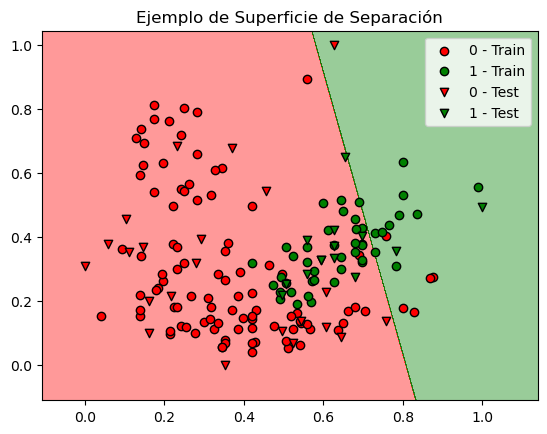

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# Función para dibujar la superficie de separación de un clasificador con 2 clases y 2 atributos
def dibujar_clasificador(clf, X_train, y_train, X_test, y_test):
    colores = ListedColormap(["r", "g"])
    DecisionBoundaryDisplay.from_estimator(clf, X_train, eps = 0.15, cmap=colores, grid_resolution=1000, response_method="predict", alpha=0.4)
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c= "r", edgecolors="k", label='0 - Train')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c= "g", edgecolors="k", label='1 - Train')
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1],  c= "r", marker = 'v', edgecolors="k", label='0 - Test')
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1],  c= "g", marker = 'v', edgecolors="k", label='1 - Test')
    plt.legend()

# Leer los ficheros de datos y pasarlos a matrices de numpy
data_train = pd.read_csv(Path+'wine_train.csv', sep = ";")
x1_train = data_train["f6"].to_numpy().reshape(-1, 1)
x2_train = data_train["f10"].to_numpy().reshape(-1, 1)
y_train  = data_train["Clase"].to_numpy()
X_train = np.c_[x1_train, x2_train]
y_train[y_train!=1]=0  # Transformar y en 0/1 Para clasificación binaria de la clase 1

print("Número de ejemplos de entrenamiento:", len(y_train))
total_clase1 = np.sum(y_train==1)
total_clase0 = np.sum(y_train==0)
print("Porcentaje de ejemplos de la clase 1:", total_clase1/len(y_train))
print("Porcentaje de ejemplos de la clase 0:", total_clase0/len(y_train))

data_test  = pd.read_csv(Path+'wine_test.csv',  sep = ";")
x1_test = data_test["f6"].to_numpy().reshape(-1, 1)
x2_test = data_test["f10"].to_numpy().reshape(-1, 1)
y_test  = data_test["Clase"].to_numpy()
X_test  = np.c_[x1_test, x2_test]
y_test[y_test!=1]=0   # Transformar y en 0/1 Para clasificación binaria de la clase 1

# Ejemplo de dibujar una superficie de separación
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1)
clf.fit(X_train, y_train)
dibujar_clasificador(clf, X_train, y_train, X_test, y_test)
plt.title("Ejemplo de Superficie de Separación")
plt.show()



Viendo los datos de entrada se puede observar que los datos de entrada ya vienen escalados, por lo que no es necesario realizar un escalado de los datos.

Hay un 31% de datos de la clase positiva y un 69% de la clase negativa, por lo que el conjunto no está balanceado pero no es un desbalanceo muy grande.

## Métricas de evaluación

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
results = pd.DataFrame() # Variable global para guardar la tabla de resultados
## Función para añadir las métricas de un modelo a la tabla de resultados
def addMetricsToResults(label, y_train, y_train_pred, y_test, y_test_pred, results_var=None, displayMetric=True):
    """
    Función que añade las métricas de un modelo a la tabla de resultados global o 
    a la tabla que se le pase como argumento.

    Parámetros:
    - label: Etiqueta para identificar el modelo.
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_train_pred: Valores predichos por el modelo para el conjunto de entrenamiento.
    - y_test: Valores reales del conjunto de prueba.
    - y_test_pred: Valores predichos por el modelo para el conjunto de prueba.
    - results_var: Tabla de resultados a la que añadir las métricas. Si no se pasa, se añaden a la tabla global.
    - displayMetric: Si es True, muestra las métricas por pantalla.

    Retorna:
    No retorna ningún valor, pero agrega una fila con las métricas calculadas a la tabla de resultados global.
    """
    global results
    
    next_res = pd.DataFrame(
        {"Label": label,
        "accuracy_train": accuracy_score(y_train, y_train_pred),
        "f1_train": f1_score(y_train, y_train_pred),
        "precision_train": precision_score(y_train, y_train_pred),
        "recall_train": recall_score(y_train, y_train_pred),

        "accuracy_test": accuracy_score(y_test, y_test_pred),
        "f1_test": f1_score(y_test, y_test_pred),
        "precision_test": precision_score(y_test, y_test_pred),
        "recall_test": recall_score(y_test, y_test_pred)
        },
        
        index=[0]
    )
    
    if displayMetric:
        display(next_res)

    if results_var is not None:
        # Añadir la fila a la tabla de resultados, concat() devuelve una nueva tabla con la fila añadida
        results_var = pd.concat([results_var, next_res], ignore_index=True) #ignore_index=True para que el índice de las filas sea consecutivo y no repita valores, si es False (por defecto) el índice de las filas es el de los dataframes que se concatenanç
        return results_var
    else:
        results = pd.concat([results, next_res], ignore_index=True)

Vamos a usar las siguientes métricas para evaluar el modelo:
- Accuracy: es la proporción de predicciones correctas. Es útil cuando el modelo está balanceado. En nuestro caso como el desbalanceo no es muy grande, también será útil.
- F1-score: es la media armónica de la precisión y el recall. Es una métrica que combina ambas métricas y es útil cuando el conjunto de datos está desbalanceado
- Precisión y recall: Aún teniendo el F1 score puede ser interesante ver la precisión y el recall por separado. La precisón mide cuantos datos son realmente positivos de los que digo que son positivos y recall es cuantospositivos identifico bien del total de positivos que hay.

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def show_confusion_matrix(y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.show()

Usaremos también la matriz de confusión para ver los resultados de las predicciones. Nos permite ver más en detalle en que casos se equivoca el modelo.

---
## 1. Regresión Logística Básica

### a) Entrenamiento del clasificador

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


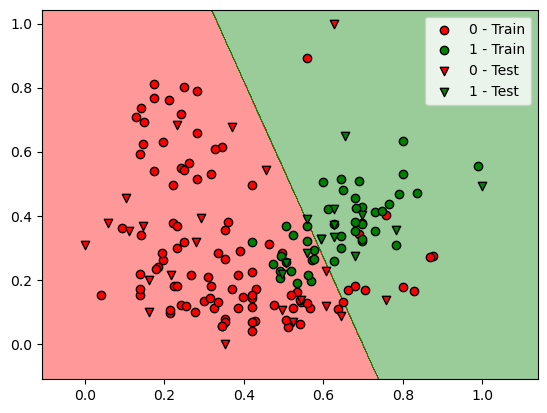

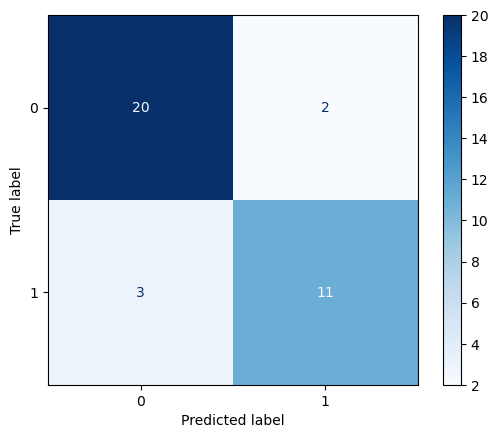

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_basic,0.809859,0.674699,0.736842,0.622222,0.861111,0.814815,0.846154,0.785714


In [63]:
from sklearn.linear_model import LogisticRegression
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# Usamos LogisticRegression porque en este caso es un problema de clasificación binaria


# Para al final poder dibujar toas las curvas de preción/recall usaremos esta variable para guardar
# los modelos que vamos a entrenar
models = []


# Entrenamos la regresión logística básica
# penalty=None es para que no se aplique regularización, es un modelo que va a estar subajustado,
# si se aplica regularización se estaría subajustando más
clf_basic = LogisticRegression(penalty='none', solver='lbfgs')
clf_basic.fit(X_train, y_train)
y_pred_train = clf_basic.predict(X_train)
y_pred_test = clf_basic.predict(X_test)

# Dibujamos la superficie de separación
dibujar_clasificador(clf_basic, X_train, y_train, X_test, y_test)
show_confusion_matrix(y_test, y_pred_test)
addMetricsToResults("LogisticRegression_basic", y_train, y_pred_train, y_test, y_pred_test)

models.append(("LogisticRegression_basic", clf_basic))


### 1.2. Discusión de los resultados

Los datos no son linealmente separables, por lo que la regresión logística no es capaz de separar bien las dos clases. A pesar de esto el modelo solo ha cometido 5 fallos en test, lo que es un buen resultado.

### 1.3. Análisis P(p=1 | atributo6=0.6, atributo10)

Antes de hacer la expansión polinómica la función de regresión logística es de grado 1 por lo que no se puede ajustar bien a los datos. 

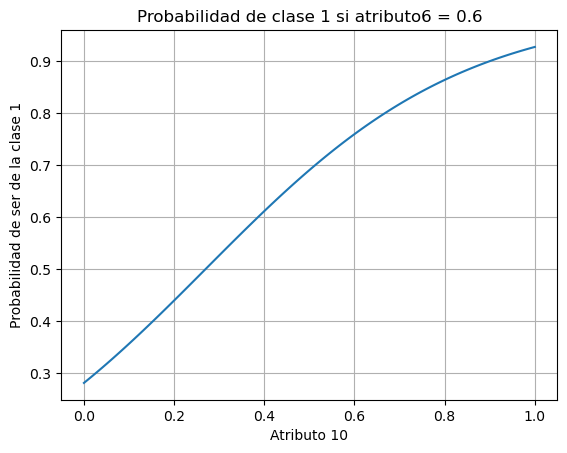

In [64]:
# Para un vino que tiene atributo 6 igual a 0.6, dibuja una gráfica con la probabilidad de que sea de la clase 1 en función del atributo 10

# Código generado con GitHub Copilot
x1 = 0.6
x2 = np.linspace(0, 1, 100).reshape(-1, 1)
X = np.c_[x1*np.ones(100), x2]
y_proba = clf_basic.predict_proba(X)[:,1]
plt.plot(x2, y_proba)
plt.xlabel("Atributo 10")
plt.ylabel("Probabilidad de ser de la clase 1")
plt.title("Probabilidad de clase 1 si atributo6 = 0.6")
plt.grid()
plt.show()

Podemos observar que si el atributo 6 es el valor fijo 0.6 la probabilidad de que sea de la clase positiva depende del valor del atributo 10. Este manifiesta una relación que parece logarítmica con la probabilidad de que sea de la clase positiva. Cuanto mayor es el atributo 10, mayor es la probabilidad de que sea de la clase positiva. Esta probabilidad aumenta en menor medida a medida que el valor de atributo 10 aumenta. Por lo que valores altos del atributo 10 tienen una probabilidad alta de ser de la clase positiva.

### 1.4. Análisis P(p=1 | atributo6 , atributo10=0.6) con expansión polinómica

Ahora haremos la gráfica al revés, es decir, fijaremos el valor del atributo 10 y veremos como cambia la probabilidad de que sea de la clase positiva en función del valor del atributo 6. Esto nos dará una idea de como se relacionan estos dos atributos con la probabilidad de que sea de la clase positiva.

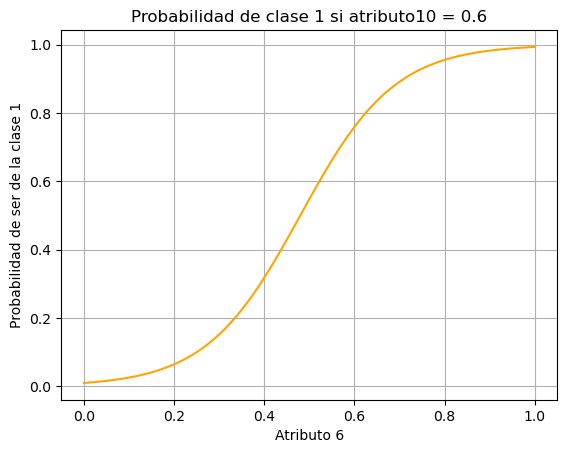

In [65]:
# Para un vino que tiene atributo 10 igual a 0.6, dibuja una gráfica con la probabilidad de que sea de la clase 1 en función del atributo 6
x1 = np.linspace(0, 1, 100).reshape(-1, 1)
x2 = 0.6
X = np.c_[x1, x2*np.ones(100)]
y_proba = clf_basic.predict_proba(X)[:,1]
plt.plot(x1, y_proba, color="orange")
plt.xlabel("Atributo 6")
plt.ylabel("Probabilidad de ser de la clase 1")
plt.title("Probabilidad de clase 1 si atributo10 = 0.6")
plt.grid()
plt.show()

Sigue una relación sigmoide, es decir, que la probabilidad de que sea de la clase positiva aumenta a medida que el valor del atributo 6 aumenta, pero a partir de un cierto valor, la probabilidad de que sea de la clase positiva aumenta en menor medida a medida que el valor del atributo 6 aumenta.

### 1.5. Análisis de la influencia de los atributos

Para hacernos una idea de como se relacionan estos dos atributos con la probabilidad de que sea de la clase positiva, vamos a hacer una gráfica 3D en la que el eje x sea el atributo 6, el eje y sea el atributo 10 y el eje z sea la probabilidad de que sea de la clase positiva.

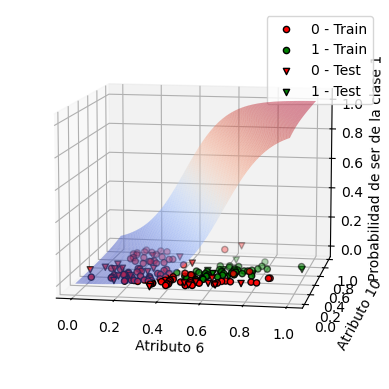

In [66]:
# Código generado con GitHub Copilot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def show_prediction_plane(model, X_train, y_train, X_test, y_test):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.ravel(), X2.ravel()]
    y_proba = model.predict_proba(X)[:,1]
    y_proba = y_proba.reshape(X1.shape)
    ax.plot_surface(X1, X2, y_proba, cmap=cm.coolwarm , alpha=0.5)
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 0, c= "r", edgecolors="k", label='0 - Train')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 0, c= "g", edgecolors="k", label='1 - Train')
    ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], 0, c= "r", marker = 'v', edgecolors="k", label='0 - Test')
    ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], 0, c= "g", marker = 'v', edgecolors="k", label='1 - Test')
    ax.set_xlabel('Atributo 6')
    ax.set_ylabel('Atributo 10')
    # para  girar la gráfica
    ax.view_init(10, 280)
    ax.set_zlabel('Probabilidad de ser de la clase 1')
    plt.legend()
    plt.show()

show_prediction_plane(clf_basic, X_train, y_train, X_test, y_test)

Al observar el plano podemos observar que ambos valores influyen practicamente por igual en la probabilidad de que la clase sea positiva. Sin embargo observamos que un valor muy alto del atributo 6 practicamente garantiza que la clase sea positiva, mientras que un valor muy alto del atributo 10 no garantiza que la clase sea positiva.

---

## 2. Regresión Logística con Expansión Polinómica

A continuación haremos una expansión polinómica de atributos de grado 6 con un modelo sin regularizar.

### 2.1. Entrenamiento del clasificador

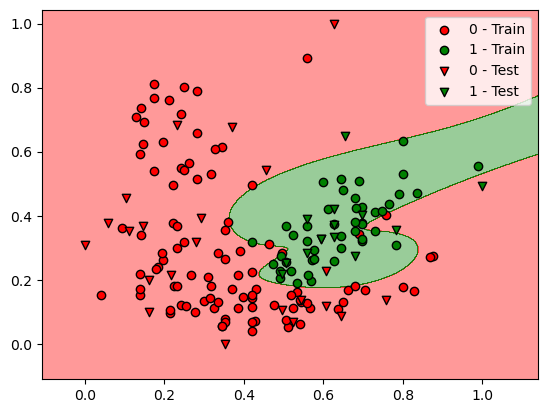

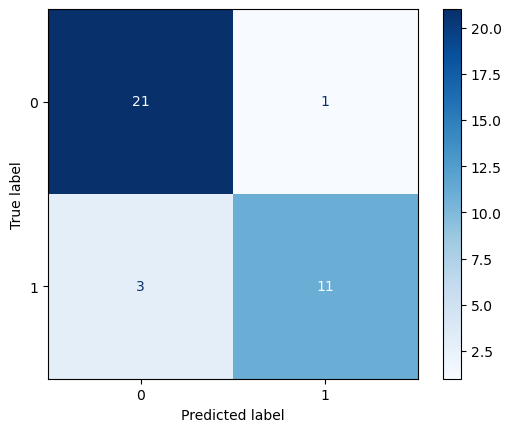

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_poly_exp,0.985915,0.978261,0.957447,1.0,0.888889,0.846154,0.916667,0.785714


In [67]:
from sklearn.preprocessing import PolynomialFeatures
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
from sklearn.pipeline import make_pipeline

clf_poly = make_pipeline(PolynomialFeatures(degree=6), LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000))
clf_poly.fit(X_train, y_train)
y_pred_train = clf_poly.predict(X_train)
y_pred_test = clf_poly.predict(X_test)

# Dibujamos la superficie de separación
dibujar_clasificador(clf_poly, X_train, y_train, X_test, y_test)
show_confusion_matrix(y_test, y_pred_test)
addMetricsToResults("LogisticRegression_poly_exp", y_train, y_pred_train, y_test, y_pred_test)

models.append(("LogisticRegression_poly_exp", clf_poly))

### Discusión de los resultados

In [68]:
results

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_basic,0.809859,0.674699,0.736842,0.622222,0.861111,0.814815,0.846154,0.785714
1,LogisticRegression_poly_exp,0.985915,0.978261,0.957447,1.000000,0.888889,0.846154,0.916667,0.785714


Las métricas obtenidas por este nuevo modelo son mejores que las obtenidas por el modelo sin expansión polinómica ya que los datos no eran linealmente separables. Sin embargo, el modelo tiene un gran sobreajuste ya que el F1-score en el conjunto de entrenamiento es mucho mayor que en el conjunto de test.

A pesar de esto es un modelo que no consigue generalizar bien debido a su gran sobreajuste.

## 3. Regresión Logística con Expansión Polinómica y Regularización

Ahora, mediante k-fold cross-validation, buscaremos el valor de lambda que minimiza el error de validación.

### 3.1. Selección del parámetro de regularización

In [69]:
from sklearn.model_selection import cross_validate
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

# Valor que toma el parámetro de regularización, cuanto más alto más regularización (penalización)
lambda_values = np.logspace(-20, 8, 30) # Intervalo ajustado tras varias pruebas
degree = 6
kfolds = 10

train_f1 = []
train_acc = []
val_f1 = []
val_acc = []

print("lambda_values:", lambda_values)

for lambda_val in lambda_values:

    # Creamos el modelo de regresión polinómica
    # C es el inverso de lambda, valores más altos de C implican menos regularización
    # Es decir, valores altos de lambda implican más regularización
    model = make_pipeline(PolynomialFeatures(degree=degree),LogisticRegression(penalty='l2', C=1/lambda_val, solver='lbfgs', max_iter=10000))

    # Realizamos la validación cruzada y obtenemos las métricas de cada partición
    scores = cross_validate(model, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['f1', 'accuracy'])

    # Guardamos las métricas medias de entrenamiento y validación
    train_f1.append(np.mean(scores['train_f1']))
    train_acc.append(np.mean(scores['train_accuracy']))
    val_f1.append(np.mean(scores['test_f1']))
    val_acc.append(np.mean(scores['test_accuracy']))


lambda_values: [1.00000000e-20 9.23670857e-20 8.53167852e-19 7.88046282e-18
 7.27895384e-17 6.72335754e-16 6.21016942e-15 5.73615251e-14
 5.29831691e-13 4.89390092e-12 4.52035366e-11 4.17531894e-10
 3.85662042e-09 3.56224789e-08 3.29034456e-07 3.03919538e-06
 2.80721620e-05 2.59294380e-04 2.39502662e-03 2.21221629e-02
 2.04335972e-01 1.88739182e+00 1.74332882e+01 1.61026203e+02
 1.48735211e+03 1.37382380e+04 1.26896100e+05 1.17210230e+06
 1.08263673e+07 1.00000000e+08]


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


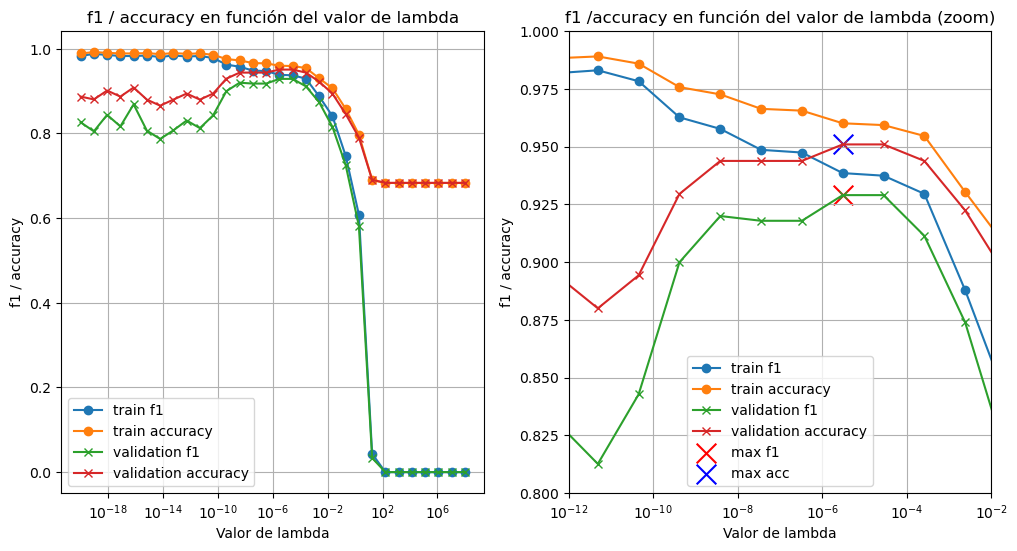

Valor de lambda que maximiza el f1 score: 3.0391953823132074e-06
f1 máximo: 0.9290043290043289
Valor de lambda que maximiza el accuracy: 3.0391953823132074e-06
accuracy máximo: 0.950952380952381


In [70]:
# Mostramos la evolución de las métricas en función del valor de lambda
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(lambda_values, train_f1, label="train f1", marker='o')
ax[0].plot(lambda_values, train_acc, label="train accuracy", marker='o')
ax[0].plot(lambda_values, val_f1, label="validation f1", marker='x')
ax[0].plot(lambda_values, val_acc, label="validation accuracy", marker='x')
ax[0].set_xlabel("Valor de lambda")
ax[0].set_xscale("log")
ax[0].set_ylabel("f1 / accuracy")
ax[0].set_title("f1 / accuracy en función del valor de lambda")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(lambda_values, train_f1, label="train f1", marker='o')
ax[1].plot(lambda_values, train_acc, label="train accuracy", marker='o')
ax[1].plot(lambda_values, val_f1, label="validation f1", marker='x')
ax[1].plot(lambda_values, val_acc, label="validation accuracy", marker='x')
ax[1].scatter(lambda_values[np.argmax(val_f1)], max(val_f1), c='red', marker='x', label='max f1', s=200)
ax[1].scatter(lambda_values[np.argmax(val_acc)], max(val_acc), c='blue', marker='x', label='max acc', s=200)
ax[1].set_xlabel("Valor de lambda")
ax[1].set_xscale("log")
ax[1].set_ylabel("f1 / accuracy")
ax[1].set_title("f1 /accuracy en función del valor de lambda (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-12, 1e-2)
ax[1].set_ylim(0.8, 1)
plt.show()

print("Valor de lambda que maximiza el f1 score:", lambda_values[np.argmax(val_f1)])
print("f1 máximo:", max(val_f1))
print("Valor de lambda que maximiza el accuracy:", lambda_values[np.argmax(val_acc)])
print("accuracy máximo:", max(val_acc))

El modelo empieza como mucho sobreajuste en valores pequeños de lambda al no tener a penas regularización. A medida que aumentamos l valor de lambda el f1-score de validación empieza a subir y el de entrenamiento a bajar, lo que indica que el modelo empieza a generalizar mejor.

A partir de un valor de lambda de en torno a 0.1 el modelo empieza a estar subajustado debido a que la regularización es muy alta.

Es notable que el valor de accuracy siempre es mayor que el de f1-score, lo que se debe a que el conjunto de datos no está balanceado.

### 3.2. Entrenamiento del clasificador

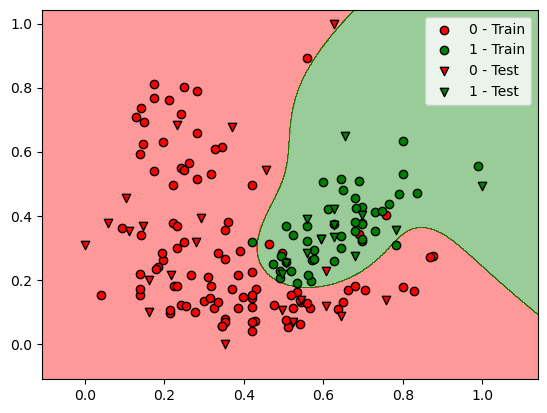

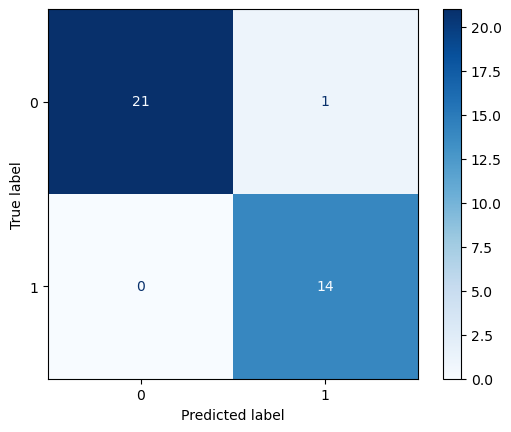

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_poly_exp_l2,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.0


In [71]:
clf_poly_reg = make_pipeline(PolynomialFeatures(degree=6), LogisticRegression(penalty='l2', C=1/lambda_values[np.argmax(val_f1)], solver='lbfgs', max_iter=1000))
clf_poly_reg.fit(X_train, y_train)
y_pred_train = clf_poly_reg.predict(X_train)
y_pred_test = clf_poly_reg.predict(X_test)

# Dibujamos la superficie de separación
dibujar_clasificador(clf_poly_reg, X_train, y_train, X_test, y_test)
show_confusion_matrix(y_test, y_pred_test)
addMetricsToResults("LogisticRegression_poly_exp_l2", y_train, y_pred_train, y_test, y_pred_test)

models.append(("LogisticRegression_poly_exp_l2", clf_poly_reg))

### 3.3. Discusión de resultados

In [72]:
results

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_basic,0.809859,0.674699,0.736842,0.622222,0.861111,0.814815,0.846154,0.785714
1,LogisticRegression_poly_exp,0.985915,0.978261,0.957447,1.000000,0.888889,0.846154,0.916667,0.785714
2,LogisticRegression_poly_exp_l2,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.000000


Sorprendentemente este modelo ha identificado correctamente todos los datos del conjunto de test menos uno. Esto nos indica que el modelo generaliza muy bien y que la regularización ha sido efectiva.

### 3.4. Análisis P(p=1 | atributo6=0.6, atributo10)

Antes de hacer la expansión polinómica la función de regresión logística es de grado 1 por lo que no se puede ajustar bien a los datos. 

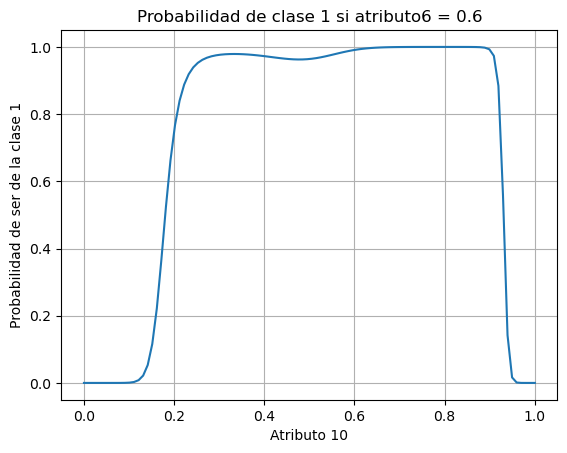

In [73]:
# Para un vino que tiene atributo 6 igual a 0.6, dibuja una gráfica con la probabilidad de que sea de la clase 1 en función del atributo 10

# Código generado con GitHub Copilot
x1 = 0.6
x2 = np.linspace(0, 1, 100).reshape(-1, 1)
X = np.c_[x1*np.ones(100), x2]
y_proba = clf_poly_reg.predict_proba(X)[:,1]
plt.plot(x2, y_proba)
plt.xlabel("Atributo 10")
plt.ylabel("Probabilidad de ser de la clase 1")
plt.title("Probabilidad de clase 1 si atributo6 = 0.6")
plt.grid()
plt.show()

Podemos observar que si el atributo 6 es el valor fijo 0.6 la probabilidad de que sea de la clase positiva depende del valor del atributo 10. Este manifiesta una relación que parece logarítmica con la probabilidad de que sea de la clase positiva. Cuanto mayor es el atributo 10, mayor es la probabilidad de que sea de la clase positiva. Esta probabilidad aumenta en menor medida a medida que el valor de atributo 10 aumenta. Por lo que valores altos del atributo 10 tienen una probabilidad alta de ser de la clase positiva.

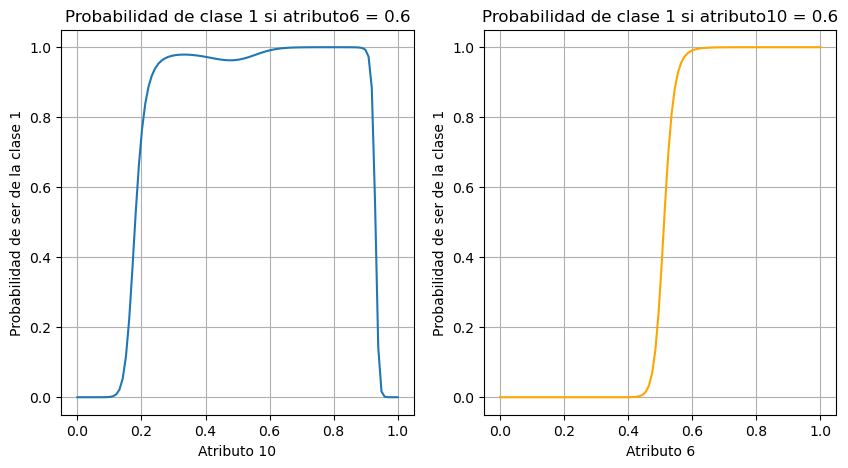

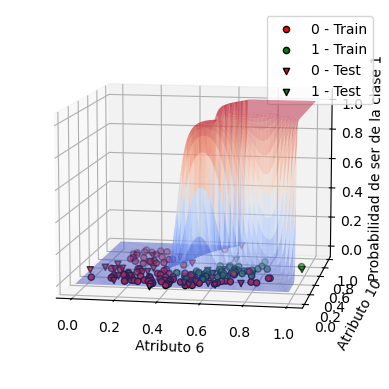

In [74]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x1 = 0.6
x2 = np.linspace(0, 1, 100).reshape(-1, 1)
X = np.c_[x1*np.ones(100), x2]
y_proba = clf_poly_reg.predict_proba(X)[:,1]
ax[0].plot(x2, y_proba)
ax[0].set_xlabel("Atributo 10")
ax[0].set_ylabel("Probabilidad de ser de la clase 1")
ax[0].set_title("Probabilidad de clase 1 si atributo6 = 0.6")
ax[0].grid()

x1 = np.linspace(0, 1, 100).reshape(-1, 1)
x2 = 0.6
X = np.c_[x1, x2*np.ones(100)]
y_proba = clf_poly_reg.predict_proba(X)[:,1]
ax[1].plot(x1, y_proba, color="orange")
ax[1].set_xlabel("Atributo 6")
ax[1].set_ylabel("Probabilidad de ser de la clase 1")
ax[1].set_title("Probabilidad de clase 1 si atributo10 = 0.6")
ax[1].grid()
plt.show()
show_prediction_plane(clf_poly_reg, X_train, y_train, X_test, y_test)


Al igual que hemos visto antes un valor alto del atributo 6 practicamente garantiza que la clase sea positiva, mientras que el atributo 10 lo hace con un valor medio, ni muy alto ni muy bajo.

---

## 4. Curvas Precisión/Recall

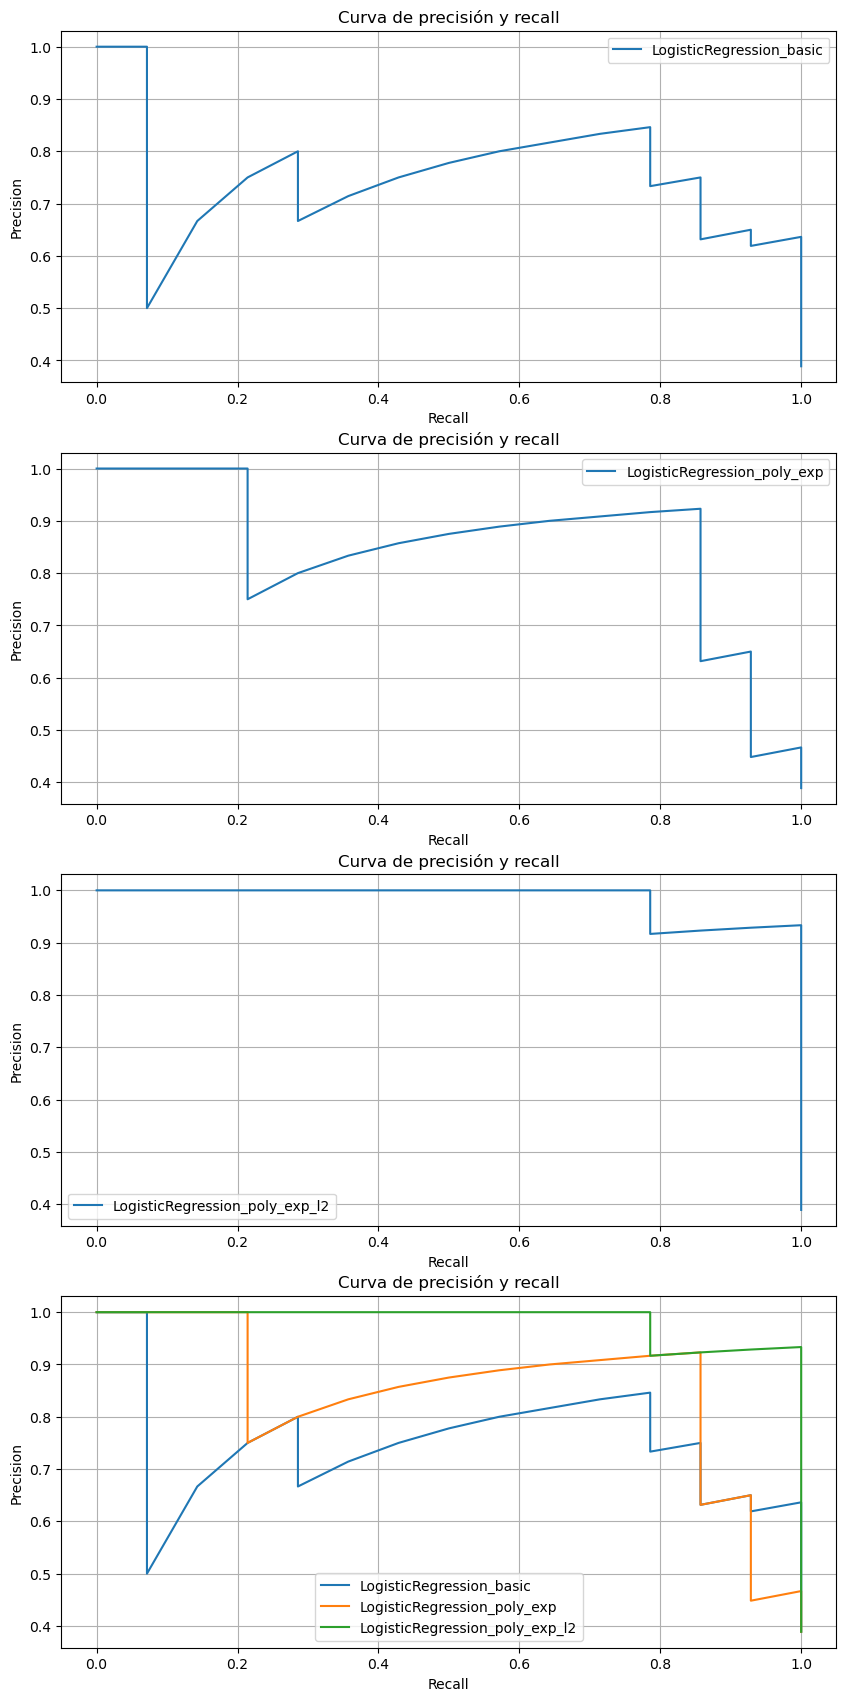

In [75]:
# Primero calculamos la precisión y recall para distintos umbrales de probabilidad
from sklearn.metrics import precision_recall_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

precisions = {}
recalls = {}
thresholds = {}

i = 0
fig, ax = plt.subplots(len(models)+1, 1, figsize=(10, 7*len(models))) # Para espaciar más las gráficas entre sí:
for label, model in models:
    # Calculamos la precisón y el recall para distintos umbrales de probabilidad
    y_proba_test = model.predict_proba(X_test)[:,1]
    precisions[label], recalls[label], thresholds[label] = precision_recall_curve(y_test, y_proba_test)

    # Hacemos una gráfica de la curva de precisión y recall conjunta y otra para cada una por separado
    ax[i].plot(recalls[label], precisions[label], label=label)
    ax[len(models)].plot(recalls[label], precisions[label], label=label)
    i+=1
    

for i in range(len(models)+1):
    ax[i].set_xlabel("Recall")
    ax[i].set_ylabel("Precision")
    ax[i].set_title("Curva de precisión y recall")
    ax[i].legend()
    ax[i].grid()


plt.show()



Es interesante destacar que todos los modelos pueden alcanzar una precisión del 100% si se aumenta el umbral de decisión lo suficiente sacrificando recall.

El modelo con expansión polinómica y regularización es el que mejor equilibra precisión y recall, seguido del modelo con expansión polinómica y por último el modelo sin expansión polinómica.

Es destacable también la similitud de las gráficas de los modelos con expansión polinómica sin regularización en su inicio. Ambos modelos parecen ser capaces de identificar la clase positiva con una precisión del 100% tan solo cuando el recall es cercano a 0, es decir, con un umbral de decisión muy alto.

### 4.2. Curvas ROC

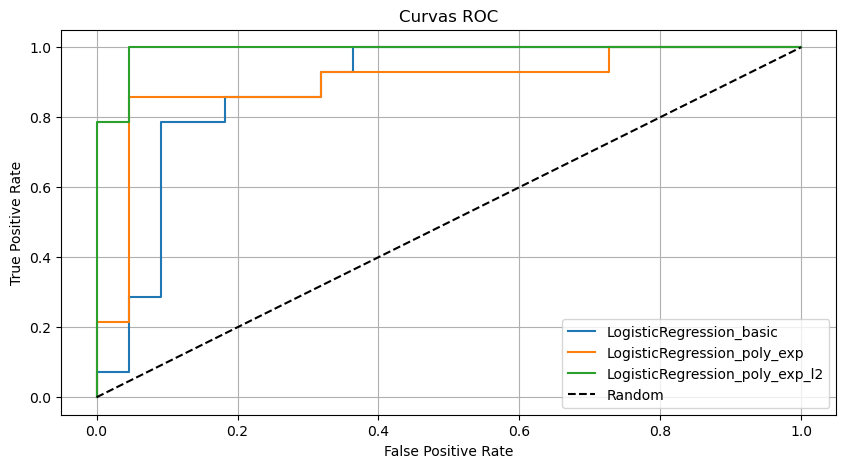

In [76]:
# Ahora mostramos la curva ROC para cada modelo
from sklearn.metrics import roc_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

fprs = {}
tprs = {}

for label, model in models:
    fprs[label], tprs[label], _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure(figsize=(10, 5)) # Para mostrarlas todas juntas
for label, _ in models:
    plt.plot(fprs[label], tprs[label], label=label)

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend()
plt.grid()
plt.show()

No aportan nueva información, los valores en general son altos y el área bajo la curva también, los modelos son buenos.

### 4.3. Ajustar el umbral de decisión

Si tenemos como objetivo garantizar que el 90% de los vinos clasificados como positivos realmente lo sean debemos ajustar el umbral de decisión de forma que la precisión sea del 90% o superior y el recall sea lo más alto posible.

In [77]:
precision_goal = 0.9

umbrales = {}

for label, model in models:
    best_recall_ind = -1
    umbrales[label] = thresholds[label][0]

    for i in range(len(precisions[label])):
        
        # Si la precisión es mayor que el objetivo y el recall es mayor que el mejor recall
        # actualizamos el umbral y el mejor recall
        if precisions[label][i] >= precision_goal and (
            recalls[label][i] > recalls[label][best_recall_ind] or best_recall_ind == -1):

            umbrales[label] = thresholds[label][i]
            best_recall_ind = i

    print("Modelo:", label)
    print(" Umbral:", umbrales[label], "Precisión:", precisions[label][best_recall_ind], "Recall:", recalls[label][best_recall_ind])

Modelo: LogisticRegression_basic
 Umbral: 0.9900255888788271 Precisión: 1.0 Recall: 0.07142857142857142
Modelo: LogisticRegression_poly_exp
 Umbral: 0.018078086463355965 Precisión: 0.9230769230769231 Recall: 0.8571428571428571
Modelo: LogisticRegression_poly_exp_l2
 Umbral: 0.6375808791211376 Precisión: 0.9333333333333333 Recall: 1.0


### 4.4. Métricas de los modelos con umbral de decisión ajustado

In [78]:
for label, model in models:
    y_pred_train = model.predict_proba(X_train)[:,1] >= umbrales[label]
    y_pred_test = model.predict_proba(X_test)[:,1] >= umbrales[label]
    
    addMetricsToResults(label + " umbral", y_train, y_pred_train, y_test, y_pred_test, displayMetric=False)

results

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
0,LogisticRegression_basic,0.809859,0.674699,0.736842,0.622222,0.861111,0.814815,0.846154,0.785714
1,LogisticRegression_poly_exp,0.985915,0.978261,0.957447,1.000000,0.888889,0.846154,0.916667,0.785714
2,LogisticRegression_poly_exp_l2,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.000000
3,LogisticRegression_basic umbral,0.690141,0.043478,1.000000,0.022222,0.638889,0.133333,1.000000,0.071429
4,LogisticRegression_poly_exp umbral,0.957746,0.937500,0.882353,1.000000,0.916667,0.888889,0.923077,0.857143
5,LogisticRegression_poly_exp_l2 umbral,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.000000


### 4.5. Discusión de los resultados

Al ajustar los umbrales de decisión hemos conseguido que todos los modelos tengan una precisión en test superior al 90% a costa de sacrificar recall. El modelo más básico tiene una precisión del 100% pero un recall del 0.07 debido a que su umbral es de 0.99.



## 5. Conclusiones

In [79]:
results.sort_values(by="f1_test", ascending=False)

,Label,accuracy_train,f1_train,precision_train,recall_train,accuracy_test,f1_test,precision_test,recall_test
2,LogisticRegression_poly_exp_l2,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.000000
5,LogisticRegression_poly_exp_l2 umbral,0.957746,0.934783,0.914894,0.955556,0.972222,0.965517,0.933333,1.000000
4,LogisticRegression_poly_exp umbral,0.957746,0.937500,0.882353,1.000000,0.916667,0.888889,0.923077,0.857143
1,LogisticRegression_poly_exp,0.985915,0.978261,0.957447,1.000000,0.888889,0.846154,0.916667,0.785714
0,LogisticRegression_basic,0.809859,0.674699,0.736842,0.622222,0.861111,0.814815,0.846154,0.785714
3,LogisticRegression_basic umbral,0.690141,0.043478,1.000000,0.022222,0.638889,0.133333,1.000000,0.071429


Al utilizar como solver lbfgs ya se obtiene la mejor solución posible, por lo que probar otras funciones no va a mejorar el modelo. El modelo con regularización l2 resulta el mejor para este conjunto de datos habiendo cometido tan solo un fallo en test.

Sin embargo, como ya se ha comentado, se dispone de un dataset muy limitado. Además en test, al visualizar los datos, se ve un dato que va a ser complicado de clasificar correctamente y que hará que todos los modelos tengan al menos un fallo. 

La mejor forma de mejorar los modelos es añadiendo más datos de entrenamiento y test para poder conseguir más información y a partir de ahí estudiar otras formas de mejorar el modelo.